In [3]:
import numpy as np
from scipy.interpolate import interp1d as interp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from thunderflask import thunderflask
from bacteria import strain
from ffgen import ffgen
from codonTable import codonTable
from codonUtils import utils
from bacteria import strain
from ffgen import ffgen
import pickle
from codonOptimizer import tableOptimizer
from queue import Queue as queue
from random import choice
from matplotlib.colors import LinearSegmentedColormap as LSC
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cProfile
import copy

In [4]:
filename='perfectBC.pickle'
PBC = copy.deepcopy(utils.standardTable)

In [5]:
newTable = PBC
newTable['UUC'] = 'K'
newTable['UUA'] = '*'
newTable['UUG'] = '*'
newTable['UUU'] = '*'

newTable['UCU'] = 'N'
newTable['UCC'] = '*'
newTable['UCG'] = '*'
newTable['UCA'] = '*'

newTable['UAC'] = '*'
newTable['UAA'] = 'R'
newTable['UAG'] = '*'
newTable['UAU'] = '*'

newTable['UGC'] = '*'
newTable['UGG'] = 'S'
newTable['UGA'] = '*'
newTable['UGU'] = '*'

newTable['CUA'] = '*'
newTable['CUC'] = '*'
newTable['CUU'] = 'Q'
newTable['CUG'] = '*'

newTable['CCU'] = '*'
newTable['CCC'] = '*'
newTable['CCA'] = '*'
newTable['CCG'] = 'I'


newTable['CAA'] = '*'
newTable['CAC'] = 'M'
newTable['CAG'] = '*'
newTable['CAU'] = '*'

newTable['CGC'] = '*'
newTable['CGU'] = '*'
newTable['CGG'] = '*'
newTable['CGA'] = 'L'

newTable['AUU'] = '*'
newTable['AUC'] = '*'
newTable['AUG'] = '*'
newTable['AUA'] = 'E'

newTable['ACC'] = 'D'
newTable['ACG'] = '*'
newTable['ACA'] = '*'
newTable['ACU'] = '*'

newTable['AAC'] = '*'
newTable['AAA'] = '*'
newTable['AAG'] = 'A'
newTable['AAU'] = '*'

newTable['AGG'] = '*'
newTable['AGC'] = '*'
newTable['AGU'] = 'H'
newTable['AGA'] = '*'

newTable['GUC'] = '*'
newTable['GUA'] = '*'
newTable['GUU'] = '*'
newTable['GUG'] = 'G'

newTable['GCC'] = '*'
newTable['GCG'] = '*'
newTable['GCA'] = 'V'
newTable['GCU'] = '*'

newTable['GAU'] = 'Y'
newTable['GAG'] = '*'
newTable['GAC'] = '*'
newTable['GAA'] = '*'

newTable['GGG'] = '*'
newTable['GGU'] = '*'
newTable['GGC'] = 'W'
newTable['GGA'] = '*'

In [6]:
with open(filename, 'wb') as handle:
    pickle.dump(PBC, handle)

In [7]:
with open('perfectBC.pickle', 'rb') as handle:
    PBCdict = pickle.load(handle)

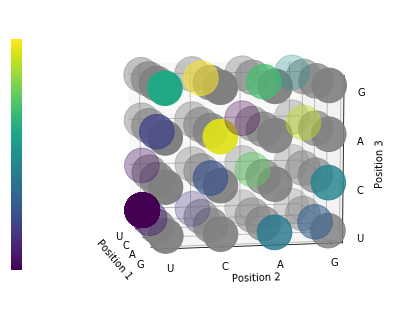

U        C        A        G
U U  UUU : *  UCU : N  UAU : *  UGU : *
  C  UUC : K  UCC : *  UAC : *  UGC : *
  A  UUA : *  UCA : *  UAA : R  UGA : *
  G  UUG : *  UCG : *  UAG : *  UGG : S
C U  CUU : Q  CCU : *  CAU : *  CGU : *
  C  CUC : *  CCC : *  CAC : M  CGC : *
  A  CUA : *  CCA : *  CAA : *  CGA : L
  G  CUG : *  CCG : I  CAG : *  CGG : *
A U  AUU : *  ACU : *  AAU : *  AGU : H
  C  AUC : *  ACC : D  AAC : *  AGC : *
  A  AUA : E  ACA : *  AAA : *  AGA : *
  G  AUG : *  ACG : *  AAG : A  AGG : *
G U  GUU : *  GCU : *  GAU : Y  GGU : *
  C  GUC : *  GCC : *  GAC : *  GGC : W
  A  GUA : *  GCA : V  GAA : *  GGA : *
  G  GUG : G  GCG : *  GAG : *  GGG : *

In [8]:
PBCTable = codonTable(PBCdict)
PBCTable.plot3d()
PBCTable.dictToTable()

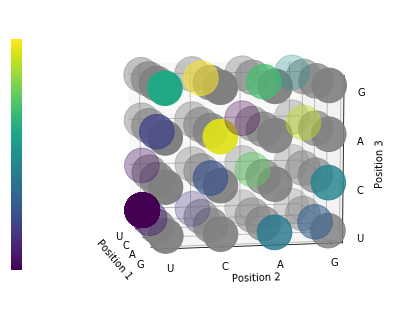

Iteration Number: 100%|██████████| 1050/1050 [00:00<00:00, 4327.86it/s]/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:571: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]



ValueError: A value in x_new is above the interpolation range.

In [9]:
PBCTable = codonTable(PBCdict)
PBCTable.plot3d()
# initialize some variables
T_curr = 0
mut_param = [1,2]
dt = 0.1
N_sims = 10
T_sim = 100
t_extra = 5
date = '2-27'
code = 'Perfect Biocontainment Code'
filepath = 'res/2-14 Traces'
filename = '{0}_{1}_favg_traces_T={2}_N={3}_b={4}_l={5}.pickle'.format(date,
                                                                       code,
                                                                       T_sim,
                                                                       N_sims,
                                                                      mut_param[0],
                                                                      mut_param[1]) 
# initialize list of dictionaries of arrays (i know, it's too much) 
dataframes = []
newtimes = np.linspace(0, T_sim, int((T_sim)/dt))
# run N simulations
for i in tqdm(range(N_sims), desc='Simulation Number: '):
    LUCA = strain(N_pop=1e6, table=PBCTable, fitness=0, mu=2e-5)
    sim = thunderflask(LUCA)
    sim.simulate(T_sim+t_extra, dt, T_curr, mut_param)
    t = sim.f_avgtrace['timepoints']
    f_avg = sim.f_avgtrace['f_avg']
    interp_fxn = interp(t, f_avg)
    newf = interp_fxn(newtimes)
    df = pd.DataFrame({
        'time' : newtimes, 
        'value' : newf, 
        'sim' : [i for j in range(len(newf))],
        'code' : [code for j in range(len(newf))]
    })
    dataframes.append(df)
# package data into pandas dataframe
df_sc = pd.concat(dataframes)
# pickle results
with open('{0}/{1}'.format(filepath, filename), 'wb') as handle:
    pickle.dump(df_sc, handle)
# plot results
ax = sns.tsplot(data=df_sc, time='time', value='value', unit='sim')
plt.title('{0}: <F> vs time ({1} Replicates)'.format(code, N_sims))
plt.xlabel('Time (in generations)')
plt.ylabel('Mean Fitness')
plt.show()
print('done')

In [10]:
t

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


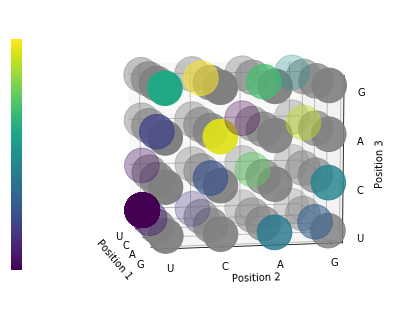

Iteration Number:  10%|█         | 101458/1000050 [00:22<03:22, 4438.99it/s]


Iteration Number:  20%|██        | 204863/1000050 [00:44<02:54, 4555.66it/s]


Iteration Number:  31%|███▏      | 312662/1000050 [01:07<02:27, 4666.03it/s]


Iteration Number:  42%|████▏     | 420896/1000050 [01:29<02:03, 4689.11it/s]


Iteration Number:  54%|█████▍    | 541052/1000050 [01:52<01:35, 4819.36it/s]


Iteration Number:  65%|██████▌   | 651193/1000050 [02:14<01:12, 4837.88it/s]


Iteration Number:  78%|███████▊  | 783636/1000050 [02:36<00:43, 5022.04it/s]


Iteration Number:  86%|████████▌ | 861776/1000050 [03:00<00:28, 4786.71it/s]


Iteration Number:  94%|█████████▎| 935807/1000050 [03:23<00:13, 4606.59it/s]


Iteration Number: 100%|██████████| 1000050/1000050 [03:38<00:00, 4579.32it/s]/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:571: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]



ValueError: A value in x_new is above the interpolation range.

In [9]:
PBCTable = codonTable(PBCdict)
PBCTable.plot3d()
# initialize some variables
T_curr = 0
mut_param = [1,2]
dt = 0.1
N_sims = 10
T_sim = 100000
t_extra = 5
date = '2-27'
code = 'Perfect Biocontainment Code'
filepath = 'res/2-14 Traces'
filename = '{0}_{1}_favg_traces_T={2}_N={3}_b={4}_l={5}.pickle'.format(date,
                                                                       code,
                                                                       T_sim,
                                                                       N_sims,
                                                                      mut_param[0],
                                                                      mut_param[1]) 
# initialize list of dictionaries of arrays (i know, it's too much) 
dataframes = []
newtimes = np.linspace(0, T_sim, int((T_sim)/dt))
# run N simulations
for i in tqdm(range(N_sims), desc='Simulation Number: '):
    LUCA = strain(N_pop=1e6, table=PBCTable, fitness=0, mu=2e-5)
    sim = thunderflask(LUCA)
    sim.simulate(T_sim+t_extra, dt, T_curr, mut_param)
    t = sim.f_avgtrace['timepoints']
    f_avg = sim.f_avgtrace['f_avg']
    interp_fxn = interp(t, f_avg)
    newf = interp_fxn(newtimes)
    df = pd.DataFrame({
        'time' : newtimes, 
        'value' : newf, 
        'sim' : [i for j in range(len(newf))],
        'code' : [code for j in range(len(newf))]
    })
    dataframes.append(df)
# package data into pandas dataframe
df_sc = pd.concat(dataframes)
# pickle results
with open('{0}/{1}'.format(filepath, filename), 'wb') as handle:
    pickle.dump(df_sc, handle)
# plot results
ax = sns.tsplot(data=df_sc, time='time', value='value', unit='sim')
plt.title('{0}: <F> vs time ({1} Replicates)'.format(code, N_sims))
plt.xlabel('Time (in generations)')
plt.ylabel('Mean Fitness')
plt.show()
print('done')

In [10]:
#LETS MAKE IT ALMOST PERFECT INSTEAD
filename='almostPerfect.pickle'
almostPerfect = copy.deepcopy(utils.standardTable)

In [11]:
newTable = almostPerfect
newTable['UUC'] = 'K'
newTable['UUA'] = '*'
newTable['UUG'] = '*'
newTable['UUU'] = '*'

newTable['UCU'] = 'N'
newTable['UCC'] = '*'
newTable['UCG'] = '*'
newTable['UCA'] = '*'

newTable['UAC'] = '*'
newTable['UAA'] = 'R'
newTable['UAG'] = '*'
newTable['UAU'] = '*'

newTable['UGC'] = '*'
newTable['UGG'] = 'S'
newTable['UGA'] = '*'
newTable['UGU'] = '*'
#here's where the "almost comes in--1 jump possible from CUC (Q) to UUC (K)
newTable['CUA'] = '*'
newTable['CUC'] = 'Q'
newTable['CUU'] = '*'
newTable['CUG'] = '*'

newTable['CCU'] = '*'
newTable['CCC'] = '*'
newTable['CCA'] = '*'
newTable['CCG'] = 'I'


newTable['CAA'] = '*'
newTable['CAC'] = 'M'
newTable['CAG'] = '*'
newTable['CAU'] = '*'

newTable['CGC'] = '*'
newTable['CGU'] = '*'
newTable['CGG'] = '*'
newTable['CGA'] = 'L'

newTable['AUU'] = '*'
newTable['AUC'] = '*'
newTable['AUG'] = '*'
newTable['AUA'] = 'E'

newTable['ACC'] = 'D'
newTable['ACG'] = '*'
newTable['ACA'] = '*'
newTable['ACU'] = '*'

newTable['AAC'] = '*'
newTable['AAA'] = '*'
newTable['AAG'] = 'A'
newTable['AAU'] = '*'

newTable['AGG'] = '*'
newTable['AGC'] = '*'
newTable['AGU'] = 'H'
newTable['AGA'] = '*'

newTable['GUC'] = '*'
newTable['GUA'] = '*'
newTable['GUU'] = '*'
newTable['GUG'] = 'G'

newTable['GCC'] = '*'
newTable['GCG'] = '*'
newTable['GCA'] = 'V'
newTable['GCU'] = '*'

newTable['GAU'] = 'Y'
newTable['GAG'] = '*'
newTable['GAC'] = '*'
newTable['GAA'] = '*'

newTable['GGG'] = '*'
newTable['GGU'] = '*'
newTable['GGC'] = 'W'
newTable['GGA'] = '*'

In [13]:
with open(filename, 'wb') as handle:
    pickle.dump(almostPerfect, handle)

In [14]:
with open('almostPerfect.pickle', 'rb') as handle:
    almostPerfectdict = pickle.load(handle)

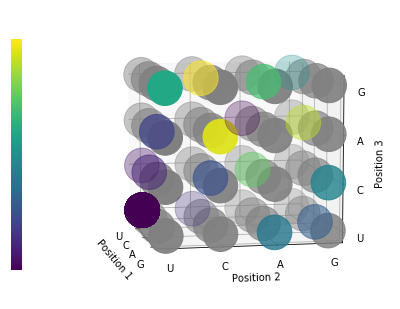

Iteration Number: 100%|██████████| 10005/10005 [00:29<00:00, 342.91it/s]


ValueError: A value in x_new is above the interpolation range.

In [17]:
almostPerfectTable = codonTable(almostPerfectdict)
almostPerfectTable.plot3d()
# initialize some variables
T_curr = 0
mut_param = [1,2]
dt = 1
N_sims = 10
T_sim = 10000
t_extra = 5
date = '2-27'
code = 'Almost Perfect Biocontainment Code'
filepath = 'res/2-14 Traces'
filename = '{0}_{1}_favg_traces_T={2}_N={3}_b={4}_l={5}.pickle'.format(date,
                                                                       code,
                                                                       T_sim,
                                                                       N_sims,
                                                                      mut_param[0],
                                                                      mut_param[1]) 
# initialize list of dictionaries of arrays (i know, it's too much) 
dataframes = []
newtimes = np.linspace(0, T_sim, int((T_sim)/dt))
# run N simulations
for i in tqdm(range(N_sims), desc='Simulation Number: '):
    LUCA = strain(N_pop=1e6, table=almostPerfectTable, fitness=0, mu=2e-5)
    sim = thunderflask(LUCA)
    sim.simulate(T_sim+t_extra, dt, T_curr, mut_param)
    t = sim.f_avgtrace['timepoints']
    f_avg = sim.f_avgtrace['f_avg']
    interp_fxn = interp(t, f_avg)
    newf = interp_fxn(newtimes)
    df = pd.DataFrame({
        'time' : newtimes, 
        'value' : newf, 
        'sim' : [i for j in range(len(newf))],
        'code' : [code for j in range(len(newf))]
    })
    dataframes.append(df)
# package data into pandas dataframe
df_sc = pd.concat(dataframes)
# pickle results
with open('{0}/{1}'.format(filepath, filename), 'wb') as handle:
    pickle.dump(df_sc, handle)
# plot results
ax = sns.tsplot(data=df_sc, time='time', value='value', unit='sim')
plt.title('{0}: <F> vs time ({1} Replicates)'.format(code, N_sims))
plt.xlabel('Time (in generations)')
plt.ylabel('Mean Fitness')
plt.show()
print('done')

In [23]:
#LETS MAKE IT LESS PERFECT
filename='notPerfect.pickle'
notPerfect = copy.deepcopy(utils.standardTable)

In [28]:
newTable = notPerfect
newTable['UUC'] = 'K'
newTable['UUA'] = '*'
newTable['UUG'] = 'T'
newTable['UUU'] = '*'

newTable['UCU'] = 'N'
newTable['UCC'] = '*'
newTable['UCG'] = '*'
newTable['UCA'] = '*'

newTable['UAC'] = '*'
newTable['UAA'] = 'R'
newTable['UAG'] = '*'
newTable['UAU'] = '*'

newTable['UGC'] = '*'
newTable['UGG'] = 'S'
newTable['UGA'] = '*'
newTable['UGU'] = '*'

newTable['CUA'] = '*'
newTable['CUC'] = '*'
newTable['CUU'] = 'Q'
newTable['CUG'] = '*'

newTable['CCU'] = '*'
newTable['CCC'] = '*'
newTable['CCA'] = '*'
newTable['CCG'] = 'I'


newTable['CAA'] = '*'
newTable['CAC'] = 'M'
newTable['CAG'] = '*'
newTable['CAU'] = 'F'

newTable['CGC'] = '*'
newTable['CGU'] = '*'
newTable['CGG'] = '*'
newTable['CGA'] = 'L'

newTable['AUU'] = '*'
newTable['AUC'] = '*'
newTable['AUG'] = '*'
newTable['AUA'] = 'E'

newTable['ACC'] = '*'
newTable['ACG'] = '*'
newTable['ACA'] = 'C'
newTable['ACU'] = 'D'

newTable['AAC'] = '*'
newTable['AAA'] = '*'
newTable['AAG'] = 'A'
newTable['AAU'] = '*'

newTable['AGG'] = '*'
newTable['AGC'] = '*'
newTable['AGU'] = 'H'
newTable['AGA'] = '*'

newTable['GUC'] = '*'
newTable['GUA'] = '*'
newTable['GUU'] = '*'
newTable['GUG'] = 'G'

newTable['GCC'] = '*'
newTable['GCG'] = '*'
newTable['GCA'] = 'V'
newTable['GCU'] = '*'

newTable['GAU'] = 'Y'
newTable['GAG'] = '*'
newTable['GAC'] = '*'
newTable['GAA'] = '*'

newTable['GGG'] = 'P'
newTable['GGU'] = '*'
newTable['GGC'] = 'W'
newTable['GGA'] = '*'

In [29]:
with open(filename, 'wb') as handle:
    pickle.dump(notPerfect, handle)

In [30]:
with open('notPerfect.pickle', 'rb') as handle:
    notPerfectDict = pickle.load(handle)

In [31]:
notPerfectTable = codonTable(notPerfectDict)
notPerfectTable.dictToTable()

U        C        A        G
U U  UUU : *  UCU : N  UAU : *  UGU : *
  C  UUC : K  UCC : *  UAC : *  UGC : *
  A  UUA : *  UCA : *  UAA : R  UGA : *
  G  UUG : T  UCG : *  UAG : *  UGG : S
C U  CUU : Q  CCU : *  CAU : F  CGU : *
  C  CUC : *  CCC : *  CAC : M  CGC : *
  A  CUA : *  CCA : *  CAA : *  CGA : L
  G  CUG : *  CCG : I  CAG : *  CGG : *
A U  AUU : *  ACU : D  AAU : *  AGU : H
  C  AUC : *  ACC : *  AAC : *  AGC : *
  A  AUA : E  ACA : C  AAA : *  AGA : *
  G  AUG : *  ACG : *  AAG : A  AGG : *
G U  GUU : *  GCU : *  GAU : Y  GGU : *
  C  GUC : *  GCC : *  GAC : *  GGC : W
  A  GUA : *  GCA : V  GAA : *  GGA : *
  G  GUG : G  GCG : *  GAG : *  GGG : P

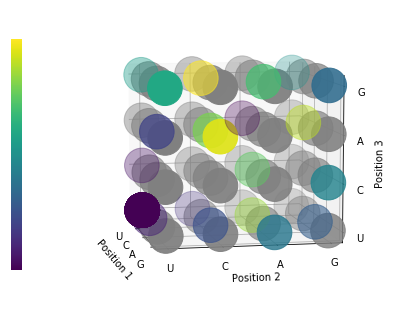

Iteration Number:  15%|█▍        | 1507/10050 [00:02<00:12, 658.52it/s]


Iteration Number:  74%|███████▍  | 7456/10050 [00:10<00:03, 694.97it/s]


Iteration Number:  98%|█████████▊| 9819/10050 [00:20<00:00, 468.19it/s]


Iteration Number:  78%|███████▊  | 7808/10050 [00:10<00:02, 774.99it/s]


Iteration Number:  40%|████      | 4035/10050 [00:03<00:05, 1136.74it/s]


Iteration Number:  78%|███████▊  | 7858/10050 [00:12<00:03, 615.31it/s]


Simulation Number: 100%|██████████| 10/10 [02:54<00:00, 17.47s/it]3it/s]
/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


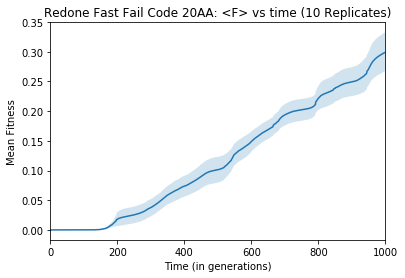

done


In [32]:
notPerfectTable = codonTable(notPerfectDict)
notPerfectTable.plot3d()
# initialize some variables
T_curr = 0
mut_param = [1,2]
dt = 0.1
N_sims = 10
T_sim = 1000
t_extra = 5
date = '2-27'
code = 'Redone Fast Fail Code 20AA'
filepath = 'res/2-14 Traces'
filename = '{0}_{1}_favg_traces_T={2}_N={3}_b={4}_l={5}.pickle'.format(date,
                                                                       code,
                                                                       T_sim,
                                                                       N_sims,
                                                                      mut_param[0],
                                                                      mut_param[1]) 
# initialize list of dictionaries of arrays (i know, it's too much) 
dataframes = []
newtimes = np.linspace(0, T_sim, int((T_sim)/dt))
# run N simulations
for i in tqdm(range(N_sims), desc='Simulation Number: '):
    LUCA = strain(N_pop=1e6, table=notPerfectTable, fitness=0, mu=2e-5)
    sim = thunderflask(LUCA)
    sim.simulate(T_sim+t_extra, dt, T_curr, mut_param)
    t = sim.f_avgtrace['timepoints']
    f_avg = sim.f_avgtrace['f_avg']
    interp_fxn = interp(t, f_avg)
    newf = interp_fxn(newtimes)
    df = pd.DataFrame({
        'time' : newtimes, 
        'value' : newf, 
        'sim' : [i for j in range(len(newf))],
        'code' : [code for j in range(len(newf))]
    })
    dataframes.append(df)
# package data into pandas dataframe
df_sc = pd.concat(dataframes)
# pickle results
with open('{0}/{1}'.format(filepath, filename), 'wb') as handle:
    pickle.dump(df_sc, handle)
# plot results
ax = sns.tsplot(data=df_sc, time='time', value='value', unit='sim')
plt.title('{0}: <F> vs time ({1} Replicates)'.format(code, N_sims))
plt.xlabel('Time (in generations)')
plt.ylabel('Mean Fitness')
plt.show()
print('done')